In [325]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, date

import random

## CFM 101: Group Assignment - Python Roboadvisor
### Team Number: 15
### Team Member Names: Landon Trinh, Ethan Zemelman, Jessie Deng
### Team Strategy Chosen: SAFE

## Goal
The focus of this project is to dynamically generate the safest possible portfolio given a file of unknown stock tickers. With a given list of stocks, the robo advisor will generate a portfolio valued at $750,000, which is composed of a minimum of 10 and maximum of 22 stocks. This portfolio will then be run from November 25, 2023 to December 4, 2023. Ultimately, the goal is to have the portfolio deviate as little as possible from the starting value. 

In this project, our goal will be to tell a convincing story to WHY we are picking our stocks. We will calculate and discuss statistics, display and intepret graphs, and explain our thought process. 

## Process
Our robo advisor is designed to process the list of stock and select desirable candidates through the following steps: 

1. Setup

Before implementing strategies, we will define some variables and constants that that will be used in later parts. 

2. Filter Stock Data

Before moving on to selecting candidates for a portfolio, we filter the stock data to eliminate stocks that do not satisfy our requirements or may have been delisted. 

3. Select Candidates of Stocks

In this step, we will calculate certain measures, including but not limited to standard deviation of expected return, beta value. We will then select candidates that possess these desirable traits. To ensure a low and stable expected return, some example of these desired traits include low beta value, low standard deviation. 

4. Select Optimal Weightings

Since stocks with a high weighting can have a more prominent effect the overall performance of a portfolio, it is crucial for stocks in the portfolio to be weighted. We will aim to achieve optimal performance by weighting the stocks in a portfolio in a way that allows for lowest deviation in portfolio value. 

5. Choose the Final Portfolio

To ensure that the best possible bundle of stocks are chosen, the robo advisor will create multiple portfolios based on different metrics, such as lowest standard deviation, lowest expected return. After obtaining the stocks and weighting of each portfolio, we optimize for the lowest standard deviation and lowest expected return to choose a final portfolio. 

## Introduction
> "Theory will only take you so far." - J. Robert Oppenheimer

Yet, throughout the many years of educations, students are taught about theory --- whether it be game theory, psychoanalytic theory. These theories are often abstract and based on various assumptions. For example, in finance, we are taught to assume that people behave rationally and with the goal to increase financial position. That is, people will not make impulse purchases; they will buy and sell stocks with the goal of earning money. 

However, in real life, there are much more complications to a situation than we assume. Therefore, more people are resorting to examining hard, cold data that does not lie. Proposed in 1952 by Harry Markowitz, the Modern Portfolio Theory is an example of such. It is a mathematical framework used to build portfolios that maximizes returns while keeping the risk below a certain level. Under this method, 

This project utilizes the Modern Portfolio Theory as an underlying framework to build a robo advisor. The robo advisor will then perform analysis and make selections to come up with a final portfolio that meets the criteria of a "safe" portfolio. A "safe" portfolio is one that deviates as little as possible from the starting value. Moreover, it is our focus to keep the difference between the initial and final value as little as possible over a short period of time. 

Diversification is a risk management strategy that focuses on mixing a wide variety of investments within a portfolio in attempt to reduce portfolio risk. Hence, we plan to create 3 sets of 22 stocks in order to maximize diversification and reduce portfolio risk, but may adjust the number of stocks based on the list of stock given as well as the statistics of these stocks. For example, the robo advisor may choose to have less than 22 stocks in a portfolio in case the vast majority of stocks have an extremely high beta values. 

## 1. Setup
Before implementing our trading strategy, we will initialize required and useful constants as part of the rules:
- Currency of valid stocks (USD or CAD)
- Required average monthly volume (150,000 shares)
- The number of stocks we wish to purchase on the start date (10-22 stocks)
- Time interval (Janurary 1, 2023 - October 31, 2023)
- Minimum number of trading days for month (18 days)
- Minimum stock weighting: $\frac{100}{2n}$%, $n$ = number of stocks in portfolio
- Maximum stock weighting: 20%
- Initial investment amount: 750,000 CAD
- Buying date of roboadvisor: November 25, 2023 - December 4, 2023
- Trading fee for each stock trade: $4.95 CAD

In the end, our roboadvisor should create two DataFrames:

1. ${\verb|Portfolio_Final|\\}$
- Index: Starts at 1 and ends at number of stocks in portfolio
- Headings: Ticker, Price (price of stock on Nov 25), Currency (CAD or USD), Shares, Value, Weight (adds up to 100%)

2. ${\verb|Stocks_Final|\\}$

We should output this DataFrame to a CSV file titled "Stocks_Group_15.csv"
- Index: Same as "Portfolio Final"
- Headings: Tickers and Shares from "Portfolio_Final"

In [326]:
# Investment amount (CAD)
capital = 750000

# Minimum and maximum number of stocks for portfolio
min_stocks = 12
max_stocks = 22

# Number of stocks to buy for portfolio
num_stocks = max_stocks

# Maximum and minimum weightings of each stock in portfolio
min_weight = 1 / (2 * num_stocks)
max_weight = 0.20

# Start and end date for roboadvisor
# buy_date = "2023-11-25"
# sell_date = "2023-12-04"

# Filtering requirements
min_trading_days = 18
min_avg_volume = 150000

## 2. Filtering
After reading in the CSV file containg stock tickers, we must filter the list of stocks to make sure they are valid stock tickers according to the following rules:

- Include stocks that have an average monthly volume of at leaest 150,000 shares based on Jan 1, 2023 - Oct 31, 2023 (drop any months that don't have at least 18 trading days)
- Stock denominated in USD or CAD

To accomplish this, we first read the csv file containing all the tickers and extract these tickers to be put into a pandas data frame. 

We then set the parameters for the filtering, which includes the start and end dates as well as filter interval. 

We use a function called get_short_months to recursively check for months that have less than 18 trading days and drop these months. We then recursively use the function called filter_volume to to determine if the stock meets the trading volume requirement. The short months with less than 18 trading days that we obtain from the get_short_months function are dropped before we perform the calculation to determine the average monthly volume. 

We then retrieve the filtered tickers, which are ones that satisifies the above mentioned requirements and therefore, can be used for our portfolio. 

In [327]:
# Read in CSV ticker file
tickers = pd.read_csv("tickers_example.csv", header=None)
tickers = tickers.rename(columns={0: "ticker"})
tickers_lst = tickers["ticker"].tolist()
tickers.head()

,ticker
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN


In [328]:
# Set parameters for filtering tickers
filter_start_date = "2023-01-01"
filter_end_date = "2023-10-31"

# Set paramters for retrieving stock data
start_date = "2021-01-01"
end_date = "2023-01-01"

In [329]:
# Determines months with less than 18 trading days
def get_short_months(market_index):
    short_months = []
    for month in range(1, 11):
        trading_days = len(market_index.history(start=str(date(2023, month, 1)), end=str(date(2023, month+1, 1))))
        if trading_days < min_trading_days:
            short_months.append(month)
    return short_months

# Keeps stocks with valid average monthly volume
def filter_volume(tickers, short_months):

    # Retrieve monthly volume data for tickers
    volume_data = yf.download(tickers=tickers, interval="1mo", start=filter_start_date, end=filter_end_date).Volume

    # Drop short months from volume DataFrame
    for short_month in short_months:
        volume_data.drop(str(date(2023, short_month, 1)))

    # Determine whether stocks meets average monthly volume requirement
    for ticker in tickers:
        if (volume_data[ticker]).mean() < min_avg_volume:
            print(f"{ticker} does not meet the required minimum average monthly volume")
            tickers.remove(ticker)

    # Return finalized list of tickers
    return tickers


# Retrieve filtered tickers
def filter_tickers(tickers):
    
    # Initialize list to separately store CAD and USD tickers
    cad_tickers = []
    usd_tickers = []
    
    for ticker in tickers:
        try:
            stock_ticker = yf.Ticker(ticker)
            base_currency = stock_ticker.fast_info["currency"]
            
            # Store ticker in appropriate list
            if base_currency == "CAD":
                cad_tickers.append(ticker)
            
            elif base_currency == "USD":
                usd_tickers.append(ticker)
    
        except:
            print(f"{ticker} may be delisted")

    # Determine months that have less than 18 trading days for CAD and USD stocks
    cad_short_months = get_short_months(yf.Ticker("^GSPTSE"))
    usd_short_months = get_short_months(yf.Ticker("^GSPC"))

    # Filter months that have an average monty volume of less than 150k
    filtered_cad_tickers = filter_volume(cad_tickers, cad_short_months)
    filtered_usd_tickers = filter_volume(usd_tickers, usd_short_months)

    # Return valid tickers
    return filtered_cad_tickers, filtered_usd_tickers

cad_tickers, usd_tickers = filter_tickers(tickers_lst)
filtered_tickers = cad_tickers + usd_tickers

# Ensures number of stocks we will buy is maximum value in case filtered length is shorter than max
if len(filtered_tickers) < max_stocks:
    num_stocks = len(filtered_tickers)
    

AGN may be delisted
CELG may be delisted
MON may be delisted
RTN may be delisted
[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  32 of 32 completed


In [330]:
# Get exchange rate data for CAD-USD
def get_exchange_data(exchange_ticker):
    exchange_data = yf.download(exchange_ticker, start=start_date, end=end_date, interval="1d").Close
    exchange_hist = pd.DataFrame(exchange_data)
    exchange_hist.rename(columns = {"Close": "CAD-USD"}, inplace=True)
    return exchange_hist

exchange_ticker = "CADUSD=X"
exchange_hist = get_exchange_data(exchange_ticker)

[*********************100%%**********************]  1 of 1 completed


In [331]:
# Create DataFrame with all closing prices of stocks

# Get CAD stock data
cad_stock_data = yf.download(tickers=cad_tickers, interval="1d", start=start_date, end=end_date).Close

# Get USD stock data
usd_stock_data = yf.download(tickers=usd_tickers, interval="1d", start=start_date, end=end_date).Close

# Align USD stock data and exchange data
aligned_usd_data = pd.merge(usd_stock_data, exchange_hist, left_index=True, right_index=True, how='outer').dropna()

# Convert all USD stock data to CAD
usd_converted_data = pd.DataFrame()
for usd_ticker in usd_tickers:
    close_data = aligned_usd_data[usd_ticker]
    usd_converted_data[usd_ticker] = close_data / aligned_usd_data["CAD-USD"]

# Combine into final DataFrame
stock_data = pd.concat([cad_stock_data, usd_converted_data], axis=1).dropna()
display(stock_data)


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  32 of 32 completed


,RY.TO,SHOP.TO,T.TO,TD.TO,AAPL,ABBV,ABT,ACN,AIG,AMZN,...,PFE,PG,PM,PYPL,QCOM,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,104.680000,139.619003,25.440001,71.940002,164.636701,134.103661,138.810834,326.270967,47.237159,202.703125,...,46.830052,175.335992,103.685115,295.050942,188.923186,206.377908,444.637397,258.271346,208.388003,58.674324
2021-01-05,105.349998,141.255997,25.709999,72.309998,167.443873,136.117649,141.178924,329.647567,48.248275,205.678889,...,47.532537,177.272465,105.302658,300.238474,194.820772,208.854324,440.688862,262.649548,206.438716,59.137687
2021-01-06,106.879997,137.604996,26.299999,74.360001,160.461696,133.819481,139.713218,330.480106,50.964966,198.890127,...,46.731616,177.648595,104.566272,287.500214,191.628787,208.143919,455.363920,265.915202,204.113354,62.118701
2021-01-07,108.070000,147.089996,26.309999,74.059998,165.815417,135.152484,140.965908,333.353348,51.788821,200.250111,...,46.937975,175.859089,105.097495,297.687557,197.200277,212.702734,462.325101,269.418394,201.379863,63.314338
2021-01-08,107.980003,151.671997,26.549999,74.110001,167.489594,136.059128,141.563902,335.055288,51.521598,201.843658,...,47.094954,176.038464,105.389697,307.531444,198.679056,217.095940,460.916658,277.546940,200.898721,62.556505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,127.730003,47.259998,26.680000,87.820000,180.000714,222.254544,147.057986,360.409834,84.943244,114.060807,...,70.295977,207.171671,137.297684,93.342277,150.665354,224.201150,717.511792,284.042584,239.052609,58.330413
2022-12-23,128.279999,45.830002,26.740000,88.330002,179.814846,222.416217,147.522903,362.861607,86.130029,116.253720,...,70.679537,208.124836,138.672623,94.134829,151.150287,224.161726,724.536820,286.250075,241.384990,58.910977
2022-12-28,127.709999,44.400002,26.139999,87.559998,170.469100,219.416068,145.840077,355.869791,85.058724,110.661549,...,68.706999,205.525908,136.521353,91.361379,144.676926,218.009477,714.728638,279.791667,234.807525,58.630873


In [332]:
# Get daily returns of stocks
daily_returns = stock_data.pct_change().dropna()
daily_returns.index = daily_returns.index.tz_localize(None, ambiguous="infer").tz_localize("UTC")
daily_returns.head()

,RY.TO,SHOP.TO,T.TO,TD.TO,AAPL,ABBV,ABT,ACN,AIG,AMZN,...,PFE,PG,PM,PYPL,QCOM,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05 00:00:00+00:00,0.006400,0.011725,0.010613,0.005143,0.017051,0.015018,0.017060,0.010349,0.021405,0.014680,...,0.015001,0.011044,0.015601,0.017582,0.031217,0.011999,-0.008880,0.016952,-0.009354,0.007897
2021-01-06 00:00:00+00:00,0.014523,-0.025847,0.022948,0.028350,-0.041699,-0.016884,-0.010382,0.002526,0.056306,-0.033007,...,-0.016850,0.002122,-0.006993,-0.042427,-0.016384,-0.003401,0.033300,0.012434,-0.011264,0.050408
2021-01-07 00:00:00+00:00,0.011134,0.068929,0.000380,-0.004034,0.033364,0.009961,0.008966,0.008694,0.016165,0.006838,...,0.004416,-0.010073,0.005080,0.035434,0.029074,0.021902,0.015287,0.013174,-0.013392,0.019248
2021-01-08 00:00:00+00:00,-0.000833,0.031151,0.009122,0.000675,0.010097,0.006708,0.004242,0.005106,-0.005160,0.007958,...,0.003344,0.001020,0.002780,0.033068,0.007499,0.020654,-0.003046,0.030171,-0.002389,-0.011969
2021-01-11 00:00:00+00:00,-0.001297,-0.009435,0.002637,0.001214,-0.019630,0.020080,-0.003219,-0.010771,-0.004696,-0.017894,...,0.021006,-0.003092,-0.005717,-0.016827,0.000309,0.004585,-0.003586,-0.003037,0.025695,0.004112


## 3. Stock Analysis

As widely known in finance, diversification plays an important role in reducing the risk of investment portfolios as it minimizes the effect that changes in a single stock can have on the entire portfolio. Since our trading strategy is to go safe, we could take advantage of this information by generating portfolios to contain as many stocks as possible. 

Since we want to diversify our portfolio as much as possible to reduce overall risk, we will choose the maximum number of stocks allowed (22 stocks). We will also place a large focus on LOW-RISK assets to reduce volatility within our portfolio.

In this part, we will utilize statastical analysis taught in the CFM 101 class to complete the selection of our portfolio candidates and final portfolio. For this section, our aim is to generate multiple portfolios each containing 22 stocks unless the statistics support it to be done in another way. For instance, in case the list of stocks contains a few stable stocks and some highly volatile ones, it may be more advantageous to take only the ones that are stable. In that case, a portfolio may be composed using less than 22 stocks. 

#### 3.1 - Standard Deviation
- Take 22 stocks with the LOWEST standard deviations'

#### 3.2 - Expected Returns
- Take 22 stocks with LOWEST expected returns

#### 3.3 - Beta Value
- Take 22 stocks with the LOWEST beta values (stock with beta less than 1 is considered less volatile than the market)

#### 3.4 - Correlation
- Get 11 pairs of stocks that have LOWEST correlation

#### 3.5 - Hybrid
- Take 22 stocks based on a mixture of the above-mentioned metrics
    - 10 stocks with the lowest standard deviation
    - 6 stocks with the lowest expected returns
    - 3 pairs of stocks with the least correlation

## 3.1 - Standard Deviation

Standard deviation is a statistic that measures the dispersion of a dataset relative to its mean with its formula given below, where $x_{i}$ is a single data point, $\overline{X}$ is the mean of the data points and $N$ is the number of data points in a given dataset: 

$$\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
$$

In finance, standard deviation is often used as a measure of the risk of investing in an asset. For example, a volatile stock will have a high standard deviation while a stable blue-chip stock will have a lower standard deviation. 

To create a safe portfolio, we want to select stocks that are less volatile, indicated by a low standard deviation. Hence, we will take a look at stocks that have the lowest standard deviations.

The get_std_returns function below calculates the standard deviation of the daily historical returns of each stocks, and sorts it from lowest to highest. 

We use this measure to create one of our portfolios by extracting 22 stocks with the lowest standard deviation of expected return. Since low standard deviation indicates a smaller spread relative to the mean, which is the expected return in our case, we know that the stock is more predictable. Therefore, a portfolio composed of these stocks will be more likely to succeed since the future movements of the stocks are more likely to be able to be predicted by our statistics. 

In [333]:
# Calculate standard deviation of returns for each stock
def get_std_returns(stocks):

    std_returns = {} 

    # Add standard deviation of each stock to DataFrame
    for stock in stocks:
        stock_std = daily_returns[stock].std()
        std_returns[stock] = stock_std

    stock_std_returns = pd.DataFrame(std_returns.items(), columns=["ticker", "std"])
    return stock_std_returns

# Get standard deviation of stock returns
stock_std_returns = get_std_returns(filtered_tickers)

# Sort from lowest to highest standard deviation
sorted_stock_std_returns = stock_std_returns.sort_values(by="std").reset_index(drop=True)
display(sorted_stock_std_returns.head(num_stocks))

,ticker,std
0,RY.TO,0.009146
1,T.TO,0.009235
2,TD.TO,0.010839
3,KO,0.012305
4,PEP,0.012432
5,CL,0.012596
6,PG,0.013055
7,BMY,0.013316
8,PM,0.014393
9,ABBV,0.014618


In [334]:
# Get stocks with lowest standard deviations
l_std_stocks = list(sorted_stock_std_returns.nsmallest(num_stocks, columns="std")["ticker"])
print(l_std_stocks)

['RY.TO', 'T.TO', 'TD.TO', 'KO', 'PEP', 'CL', 'PG', 'BMY', 'PM', 'ABBV', 'MRK', 'UNH', 'UNP', 'MO', 'LMT', 'ABT', 'ACN', 'USB', 'PFE', 'UPS', 'BK', 'BAC']


## 3.2 - Expected Returns

Expected return is the profit or loss that an investor can anticipate and it can be calculated using the following formula: 

\begin{align*}
E(X)=\overline{X}=\frac{\sum x_i}{N}
\end{align*}

where $x_i$ are individual returns of some security $X$, 
$N$ is the total number of observations (time periods for us)

Expected return is important to know when investing as it allows investors to have a sense of what the outcome of the invesment may be based on historical data. Since we are choosing to go safe as our strategy, we could use this to our advantage by creating a portfolio that has an overall value to be closest to 0. In this case, we are assuming equal weights for each stock in our calculations. 

In our code, we first use the get_expected_returns to obtain the expected return of all stocks on the ticker list and store these into a data frame. We then sort these stocks from lowest to highest expected return. The sorted list of stocks is then put into the get_minimum_returns function which recursively calculates the total expected return of the top 22 stocks on the sorted list and moves up by one each time. We then take the set of 22 stocks that gives the lowest total expected return to compose the second portfolio candidate. 

In [335]:
# Calculate expected returns for each stock
def get_expected_returns(stocks):

    expected_returns = {} 

    # Calculate average reteurn for stock and add to DataFrame
    for stock in stocks:
        stock_expected_return = daily_returns[stock].mean()
        expected_returns[stock] = stock_expected_return

    stock_expected_returns = pd.DataFrame(expected_returns.items(), columns=["ticker", "expected_return"])
    return stock_expected_returns

# Get expected returns of stocks
stock_expected_returns = get_expected_returns(filtered_tickers)

# Sort from lowest to highest expected returns
sorted_stock_expected_returns = stock_expected_returns.sort_values(by="expected_return").reset_index(drop=True)
sorted_stock_expected_returns

,ticker,expected_return
0,PYPL,-0.001756
1,SHOP.TO,-0.001203
2,AMZN,-0.000844
3,C,-0.000263
4,QCOM,-0.000119
5,CL,0.000070
6,T.TO,0.000097
7,USB,0.000184
8,ABT,0.000272
9,UNP,0.000291


In [336]:
# Function that helps graph given input
def graph_relationship(x, y, x_title, y_title):
    plt.scatter(x, y)
    plt.title(f"{x_title} vs. {y_title}")
    plt.xlabel(f"{x_title} (%)")
    plt.ylabel(f"{y_title} (%)")
    plt.show()

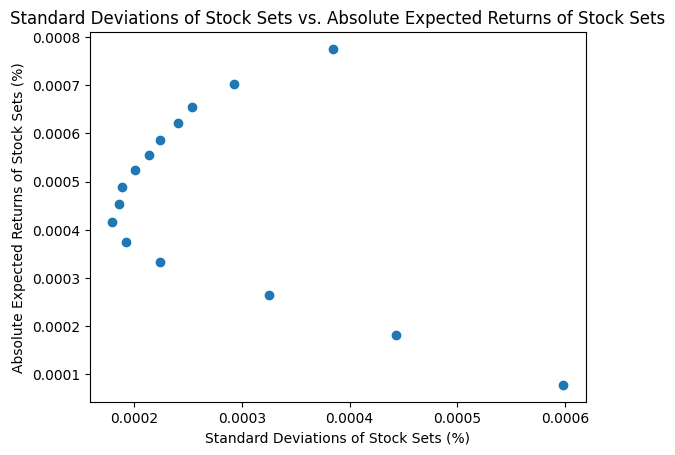

Set of Stocks with Lowest Expected Returns:
['PYPL', 'SHOP.TO', 'AMZN', 'C', 'QCOM', 'CL', 'T.TO', 'USB', 'ABT', 'UNP', 'BLK', 'AAPL', 'BA', 'TXN', 'ACN', 'PG', 'UPS', 'RY.TO', 'TD.TO', 'MO', 'BK', 'BAC']


In [337]:
def get_minimal_returns(returns_df):

    # Calculate number of possible combinations
    combinations = (returns_df.shape[0] - num_stocks) + 1

    # Store sets of stocks, and their absolute expected returns and standard deviations
    stock_sets = []
    stock_sets_er = []
    stock_sets_std = []

    for _ in range(combinations):

        # Get set of 22 stocks
        stock_set_df = returns_df.head(num_stocks)

        # Get stock set and its average expected return and standard deviation
        stock_set = list(stock_set_df["ticker"])
        stock_set_er = stock_set_df["expected_return"].mean()
        stock_set_std = stock_set_df["expected_return"].std()

        # Store information in separate lists
        stock_sets.append(stock_set)
        stock_sets_er.append(abs(stock_set_er))
        stock_sets_std.append(stock_set_std)

        # Drop first row
        returns_df = returns_df.drop(returns_df.index[0])
    
    graph_relationship(stock_sets_std, stock_sets_er, "Standard Deviations of Stock Sets", "Absolute Expected Returns of Stock Sets")

    # Get index that produces least absolute return
    min_er_index = stock_sets_er.index(min(stock_sets_er))

    # Return list of stocks that produce lowest expected return
    stock_minimal_returns = stock_sets[min_er_index]
    return stock_minimal_returns

# Print stocks with lowest expected returns on average
l_er_stocks = get_minimal_returns(sorted_stock_expected_returns)
print("Set of Stocks with Lowest Expected Returns:")
print(l_er_stocks)

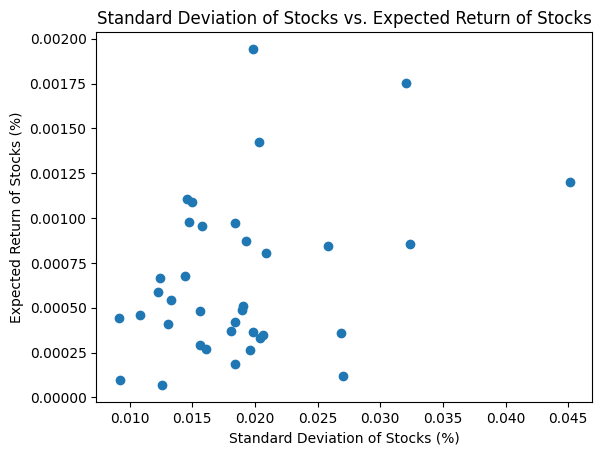

In [338]:
# Graph the correlation between the standard deviation and expected returns for stocks
stock_stds = stock_std_returns["std"]
stock_ers = abs(stock_expected_returns["expected_return"])
graph_relationship(stock_stds, stock_ers, "Standard Deviation of Stocks", "Expected Return of Stocks")


As a measure to examine the relationship between standard deviation and expected return, we made a scatter plot of the stocks with the x-axis as the standard deviation and the y-axis as the magnitude (absolute value) of the expected return. Although the relationship does not appear to be very strong, we can tell that there is somewhat of a positive relationship between standard deviation and the magnitude of the expected return. That is, we get that a low standard deviation often indicates a low expected return. Low standard deviation means that there are little movements in the daily return of the stock prices, which means stock prices does not change much from day to day. This means that the return will also be low. 

## 3.3 Beta Value
The beta value of a stock measures its volatility relative to the broader market. A beta value greater than 1 indicates that the stock is more volatile than the market and a beta value less than 1 indicates a more stable stock. Since we are choosing to go safe with our portfolio, stocks need to be chosen so that the beta values are as low as possible.

The formula of beta value of a stock relative to the market is as follows, where  ${Cov(r_i,r_m)}$  is the covariance between the stock and the market index,  ${Var(r_m)}$  is the variance of the market index: 

\begin{align*}
\beta=\frac{Cov(r_i,r_m)}{Var(r_m)}
\end{align*}

where ${r_i}$ and ${r_m}$ represent the expected return of the stock index that of market index respectively. In our calculation, we use the S&P 500 as the stock market index. 

The S&P 500 is a stock market index tracking the stock performance of the largest companies listed on the US stock exchange. Because of the sizes of these companies as well as the diversity of the companies on the S&P 500, this index is a reasonably accurate representation of the market. 

Since we are choosing to go safe with our portfolio, stocks need to be chosen so as to obtain as low of a beta value as possible. Moreover, as a volatile stock may lead to capital gains/losses, we look for the lowest magnitude beta values by taking the absolute value. The aim of this part is to use beta value as a statistical measure to quantify our various portfolios which will allow us to choose the appropriate set of stocks. 

This measure is used to create our second portfolio candidate, which is either composed of the 22 stocks with the lowest beta values if all of these values are less than one, or a minimum of 10 stocks with beta values less than one. We make this choice because a beta value greater than one indicates greater volatility than the market. Although it is important to hold a diversified portfolio, we do not want to take on more volatile stocks that could make the portfolio more risky. 

In [339]:
# Set S&P 500 as market index
market_index = yf.download(tickers="^GSPC", start=start_date, end=filter_end_date)["Close"]
market_returns = market_index.pct_change().dropna()
market_returns.index = market_returns.index.tz_localize(None, ambiguous="infer").tz_localize("UTC")
market_variance = market_returns.var()

# Get betas of every stock compared to S&P 500
def get_stock_betas(stocks): 
        betas = {}

        for stock in stocks:
                stock_returns = daily_returns[stock]
                covariance = stock_returns.cov(market_returns)
                stock_beta = covariance / market_variance
                betas[stock] = stock_beta
        
        stock_betas = pd.DataFrame(betas.items(), columns=["ticker", "beta"])
        return stock_betas

# Returns stock betas
stock_betas = get_stock_betas(filtered_tickers)

# Sorts stock betas
sorted_stock_betas = stock_betas.sort_values(by="beta").reset_index(drop=True)
display(sorted_stock_betas)

[*********************100%%**********************]  1 of 1 completed


,ticker,beta
0,MRK,0.358020
1,BMY,0.387367
2,T.TO,0.390935
3,LMT,0.398548
4,CL,0.448085
5,MO,0.478027
6,RY.TO,0.502261
7,ABBV,0.518479
8,PFE,0.518522
9,TD.TO,0.542868


In [340]:
# Exctracts stocks with beta less than 1
l_beta_stocks = list(stock_betas[stock_betas["beta"] < 1]["ticker"])

# Ensures list is diversified if list of lowest beta stocks are not enough
if len(l_beta_stocks) < num_stocks:
    for stock in l_std_stocks:
        if stock not in l_beta_stocks:
            l_beta_stocks.append(stock)

            if len(l_beta_stocks) == num_stocks:
                break

print("Lowest Beta Stocks:")
print(l_beta_stocks)

Lowest Beta Stocks:
['RY.TO', 'T.TO', 'TD.TO', 'ABBV', 'ABT', 'BIIB', 'BMY', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'UNH', 'UNP', 'USB', 'ACN']


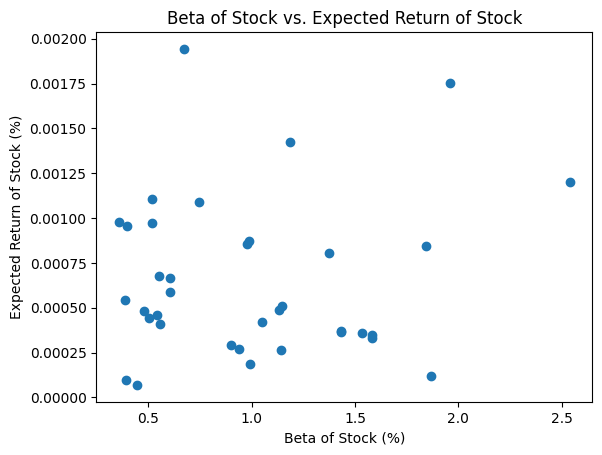

In [341]:
# Graph relationship between beta and expected returns for each stock
graph_relationship(stock_betas["beta"], stock_ers, "Beta of Stock", "Expected Return of Stock")

As shown above, we see that the data points on the graph with expected return vs beta value is pretty randomly dispersed. This indicates that there may not be a correlation between the expected return and volatility. Therefore, although we are including this portfolio with the lowest 22 expected returns, it is likely that this portfolio may be less accurate than the other ones. For this reason, we are also not including the expected return measure in the hybrid portfolio that we generate later on as we want the portfolio to be as stable as possible. 

## 3.4 - Correlation

In finance, correlation is a statistic that measures the degree to which two securities move in relation to each other. Correlation is closely tied to diversification. Correlations are computed as the correlation coefficent which takes on a value between -1 and 1. 

The formula of the correlation between $X$ and $Y$ is given as follows, 

where $\sigma_X$ and $\sigma_Y$ is the deviation of the stock, and the deviation of the market index respectively: 

$$ COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y} $$

A positive correlation indicates that when one security moves up or down, the other security moves in the same direction. A negative correlation indicates that two assets move in opposite directions, while a zero correlation implies no relationship at all. 

Hence, we hope to factor in negatively correlated stocks in our portfolio since their opposite movements in prices should theoretically offset each other to produce minimal volatility within the portfolio. 

In this part, we first calculate the correlation of expected return of all possible pairs of stocks on a given ticker list. We sort these pairs based on their correlation values. Since in step 1, we calculated the correlation of all stocks with each other, a stock may appear more than once. In the next step, we remove these duplicates and loops through the pairs to get the 11 least correlated pairs of unique stocks. These 22 stocks will then be used to make up the third portfolio. 

In [342]:
# Get stock correlation pairs
corr_pairs = daily_returns.corr()

# Sort pairs by lowest correlations
corr_pairs["Stock 1"] = corr_pairs.index
corr_pairs = corr_pairs.melt(id_vars="Stock 1", var_name="Stock 2")
corr_pairs.rename(columns={"value" : "Correlation"}, inplace=True)
corr_pairs.sort_values(by="Correlation", inplace=True)

# Remove duplicates within dataframe
corr_pairs = corr_pairs.iloc[:-(num_stocks)]
corr_pairs = corr_pairs.iloc[::2].reset_index(drop=True)
display(corr_pairs.head(num_stocks))

# Loop through pairs and get least correlated pairs of unique stocks
l_corr_pairs = []
for _, pair in corr_pairs.iterrows():
    stock1 = pair["Stock 1"]
    stock2 = pair["Stock 2"]

    if stock1 not in l_corr_pairs and stock2 not in l_corr_pairs:
        l_corr_pairs.append(stock1)
        l_corr_pairs.append(stock2)
    
    if len(l_corr_pairs) == num_stocks:
        break

print("Pairs of Least Correlated Stocks:")
print(l_corr_pairs)


,Stock 1,Stock 2,Correlation
0,SHOP.TO,MO,-0.027444
1,SHOP.TO,MRK,0.016608
2,SHOP.TO,LMT,0.037686
3,SHOP.TO,CL,0.047840
4,SHOP.TO,PM,0.051419
5,SHOP.TO,PFE,0.052125
6,SHOP.TO,BMY,0.059311
7,SHOP.TO,KO,0.079145
8,SHOP.TO,LLY,0.088652
9,LMT,PYPL,0.089447


Pairs of Least Correlated Stocks:
['SHOP.TO', 'MO', 'LMT', 'PYPL', 'MRK', 'BA', 'PFE', 'RY.TO', 'TD.TO', 'BIIB', 'LLY', 'CAT', 'BMY', 'AMZN', 'T.TO', 'ABBV', 'QCOM', 'PM', 'AXP', 'CL', 'C', 'PEP']


Text(0.5, 1.0, 'Tech Stocks Correlation Matrix')

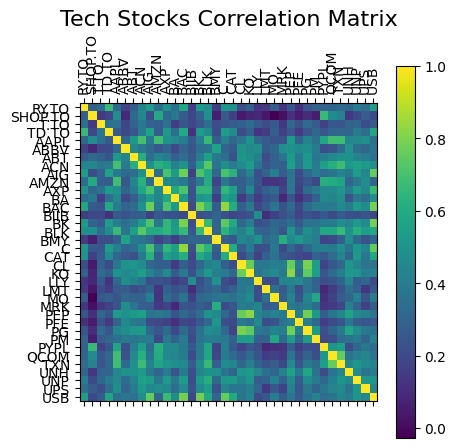

In [346]:
# Create correlation matrix
corr_matrix = daily_returns.corr()

# Create heat map for correlation matrix
plt.matshow(corr_matrix)
plt.xticks(range(daily_returns.shape[1]), daily_returns.columns, rotation=90, fontsize=10)
plt.yticks(range(daily_returns.shape[1]), daily_returns.columns, fontsize=10)

# Add a colorbar legend
cb = plt.colorbar()

plt.title("Tech Stocks Correlation Matrix", fontsize=16)

To visually examine the correlation, we've also created a correlation matrix that assigns the correlation between every two stocks a colour. The warmer the colour, meaning the closer to yellow it is, is the higher the correlation. For example, yellow would indicate a correlation of 1 whereas dark purple indicates a correlation of 0. As shown below, the diagonal of this graph is entirely yellow due to the fact that these are the correlations of the stock and itself, which gives a correlation of 1. Examining this graph, we know that the pairs chosen should be the one with lighter colours. 


## 3.5 - Hybrid Portfolio

Although standard deviation, betas and correlations are both good measures to use when choosing stocks, there may be certain downsides and uncertainties as they do not take the other measures into account as much. So as a final measure, we want to create a mixed portfolio that encapsulates stocks with the lowest standard deviations, betas, and correlations, in an attempt to diverisfy and reduce risk.

In this portfolio, we will choose 22 stocks using the following criteria: 
- 6 stocks with least correlation with each other
- 10 stocks with lowest standard deviations
- 6 stocks with lowest betas

We chose to have 10 stocks with the lowest standard deviation to ensure that it will be reasonably easy for the expected return of the entire portfolio to be predicted. 

There are 6 stocks with lowest betas in an attempt to obtain a somewhat stable portfolio. It's also important to note that in real life, stocks that have low betas are also likely to have low standard deviations and vice versa. This is because if a stock has a low standard deviation, its expected return will not have changed much. Then that means the stock probably did not change very much compared to the general market either. So from this, we know that 16/22, which is a majority of our portfolio will be relatively stable and easy to predict. 

The final 6 stocks are then chosen to have least correlation with each other. The correlation coefficient assesses whether the movement of two stocks are correlated in our case. By choosing 3 pairs of stocks with a correlation coefficient that is as small as possible, we know that in case one stock plummets or skyrockets, the other ones will not change significantly. This measure is implemented to lower the risk of the prices of many stocks in the portfolio either increasing or decreasing as it could jeopardize our portfolio. 

As we are going safe, we want to first make sure that the returns of the portfolio is predictable and stable, and then optimize for a 0 return over time. However, as mentioned earlier in part 3.3, there is a low correlation between the expected return and beta value. This means that stocks with low returns are not necessarily less volatile. Therefore, we have excluded this measure in our hybrid portfolio. 


In [344]:
# Number of stocks to get for each category
n_corr_stocks = 6
n_std_stocks = 10
n_beta_stocks = 6

hybrid_stock_lst = []

def add_unique_stocks(stock_lst, n_stocks):
    unique_stocks = []

    for stock in stock_lst:
        if stock not in hybrid_stock_lst:
            unique_stocks.append(stock)

            if len(unique_stocks) == n_stocks:
                return unique_stocks

# Add lowest correlated pairs
hybrid_stock_lst += l_corr_pairs[:n_corr_stocks]

# Add loweset stds
hybrid_stock_lst += add_unique_stocks(l_std_stocks, n_std_stocks)

# Add loweset beta stocks
hybrid_stock_lst += add_unique_stocks(l_beta_stocks, n_beta_stocks)

print("Final Hybrid Stock List:")
print(hybrid_stock_lst)

Final Hybrid Stock List:
['SHOP.TO', 'MO', 'LMT', 'PYPL', 'MRK', 'BA', 'RY.TO', 'T.TO', 'TD.TO', 'KO', 'PEP', 'CL', 'PG', 'BMY', 'PM', 'ABBV', 'ABT', 'BIIB', 'CAT', 'LLY', 'PFE', 'UNH']


### Preparing DataFrames For Portfolio Weightings

Based on the calculations we've conducted above, we prepare the data frames so that the portfolios could be weighted in the next step. 

Five seperate data frames are created: 
- 1. 22 stocks with the lowest standard deviations
- 2. 22 stocks with the lowest beta values
- 3. 22 stocks with the lowest expected returns
- 4. 11 pairs of stocks with the least correlation to each other
- 5. 22 stocks chosen using a mixture of beta values, standard deviations, expected returns

These data frames are then stored in a list to be used later on. 

In [347]:
# Get DataFrames for each set of stock candidates

# 1. Lowest standard deviations
l_std_stocks_df = stock_data[l_std_stocks]
display(l_std_stocks_df.head())

# 2. Lowest betas
l_beta_stocks_df = stock_data[l_beta_stocks]
display(l_beta_stocks_df.head())

# 3. Lowest returns
l_er_stock_df = stock_data[l_er_stocks]
display(l_er_stock_df.head())

# 4. Least correlated stocks
l_corr_stocks_df = stock_data[l_corr_pairs]
display(l_corr_stocks_df.head())

# 5. Hybrid stock candidates
hybrid_stock_df = stock_data[hybrid_stock_lst]
display(hybrid_stock_df.head())

# Store portfolio DataFrames in a list
portfolio_candidates = [l_std_stocks_df, l_beta_stocks_df, l_er_stock_df, l_corr_stocks_df, hybrid_stock_df]

,RY.TO,T.TO,TD.TO,KO,PEP,CL,PG,BMY,PM,ABBV,...,UNP,MO,LMT,ABT,ACN,USB,PFE,UPS,BK,BAC
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,104.680000,25.440001,71.940002,67.121798,183.541743,107.285472,175.335992,78.088251,103.685115,134.103661,...,258.271346,51.957057,438.454475,138.810834,326.270967,58.674324,46.830052,208.388003,53.038433,38.204467
2021-01-05,105.349998,25.709999,72.309998,66.691258,184.941065,108.025007,177.272465,78.667054,105.302658,136.117649,...,262.649548,52.095354,445.788507,141.178924,329.647567,59.137687,47.532537,206.438716,53.884695,38.675306
2021-01-06,106.879997,26.299999,74.360001,64.032583,181.159473,104.249405,177.648595,78.202898,104.566272,133.819481,...,265.915202,52.498604,441.117570,139.713218,330.480106,62.118701,46.731616,204.113354,57.048821,40.749161
2021-01-07,108.070000,26.309999,74.059998,63.276338,180.443958,103.602977,175.859089,78.981436,105.097495,135.152484,...,269.418394,52.916040,433.853267,140.965908,333.353348,63.314338,46.937975,201.379863,57.348930,41.618506
2021-01-08,107.980003,26.549999,74.110001,64.788857,182.875031,104.451098,176.038464,79.261074,105.389697,136.059128,...,277.546940,52.751928,426.302554,141.563902,335.055288,62.556505,47.094954,200.898721,56.823427,41.260403


,RY.TO,T.TO,TD.TO,ABBV,ABT,BIIB,BMY,CAT,CL,KO,...,MO,MRK,PEP,PFE,PG,PM,UNH,UNP,USB,ACN
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,104.680000,25.440001,71.940002,134.103661,138.810834,309.083417,78.088251,231.733045,107.285472,67.121798,...,51.957057,98.280649,183.541743,46.830052,175.335992,103.685115,444.637397,258.271346,58.674324,326.270967
2021-01-05,105.349998,25.709999,72.309998,136.117649,141.178924,314.911056,78.667054,234.710282,108.025007,66.691258,...,52.095354,98.906404,184.941065,47.532537,177.272465,105.302658,440.688862,262.649548,59.137687,329.647567
2021-01-06,106.879997,26.299999,74.360001,133.819481,139.713218,314.015684,78.202898,245.711728,104.249405,64.032583,...,52.498604,99.631850,181.159473,46.731616,177.648595,104.566272,455.363920,265.915202,62.118701,330.480106
2021-01-07,108.070000,26.309999,74.059998,135.152484,140.965908,317.192285,78.981436,246.000062,103.602977,63.276338,...,52.916040,101.540733,180.443958,46.937975,175.859089,105.097495,462.325101,269.418394,63.314338,333.353348
2021-01-08,107.980003,26.549999,74.110001,136.059128,141.563902,320.316698,79.261074,246.395508,104.451098,64.788857,...,52.751928,100.490072,182.875031,47.094954,176.038464,105.389697,460.916658,277.546940,62.556505,335.055288


,PYPL,SHOP.TO,AMZN,C,QCOM,CL,T.TO,USB,ABT,UNP,...,BA,TXN,ACN,PG,UPS,RY.TO,TD.TO,MO,BK,BAC
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,295.050942,139.619003,202.703125,76.510709,188.923186,107.285472,25.440001,58.674324,138.810834,258.271346,...,257.902414,206.377908,326.270967,175.335992,208.388003,104.680000,71.940002,51.957057,53.038433,38.204467
2021-01-05,300.238474,141.255997,205.678889,78.858771,194.820772,108.025007,25.709999,59.137687,141.178924,262.649548,...,270.484308,208.854324,329.647567,177.272465,206.438716,105.349998,72.309998,52.095354,53.884695,38.675306
2021-01-06,287.500214,137.604996,198.890127,82.702415,191.628787,104.249405,26.299999,62.118701,139.713218,265.915202,...,267.474185,208.143919,330.480106,177.648595,204.113354,106.879997,74.360001,52.498604,57.048821,40.749161
2021-01-07,297.687557,147.089996,200.250111,83.616968,197.200277,103.602977,26.309999,63.314338,140.965908,269.418394,...,269.405735,212.702734,333.353348,175.859089,201.379863,108.070000,74.059998,52.916040,57.348930,41.618506
2021-01-08,307.531444,151.671997,201.843658,82.914010,198.679056,104.451098,26.549999,62.556505,141.563902,277.546940,...,266.232972,217.095940,335.055288,176.038464,200.898721,107.980003,74.110001,52.751928,56.823427,41.260403


,SHOP.TO,MO,LMT,PYPL,MRK,BA,PFE,RY.TO,TD.TO,BIIB,...,BMY,AMZN,T.TO,ABBV,QCOM,PM,AXP,CL,C,PEP
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,139.619003,51.957057,438.454475,295.050942,98.280649,257.902414,46.830052,104.680000,71.940002,309.083417,...,78.088251,202.703125,25.440001,134.103661,188.923186,103.685115,150.171670,107.285472,76.510709,183.541743
2021-01-05,141.255997,52.095354,445.788507,300.238474,98.906404,270.484308,47.532537,105.349998,72.309998,314.911056,...,78.667054,205.678889,25.709999,136.117649,194.820772,105.302658,151.672124,108.025007,78.858771,184.941065
2021-01-06,137.604996,52.498604,441.117570,287.500214,99.631850,267.474185,46.731616,106.879997,74.360001,314.015684,...,78.202898,198.890127,26.299999,133.819481,191.628787,104.566272,155.974851,104.249405,82.702415,181.159473
2021-01-07,147.089996,52.916040,433.853267,297.687557,101.540733,269.405735,46.937975,108.070000,74.059998,317.192285,...,78.981436,200.250111,26.309999,135.152484,197.200277,105.097495,154.087263,103.602977,83.616968,180.443958
2021-01-08,151.671997,52.751928,426.302554,307.531444,100.490072,266.232972,47.094954,107.980003,74.110001,320.316698,...,79.261074,201.843658,26.549999,136.059128,198.679056,105.389697,154.463325,104.451098,82.914010,182.875031


,SHOP.TO,MO,LMT,PYPL,MRK,BA,RY.TO,T.TO,TD.TO,KO,...,PG,BMY,PM,ABBV,ABT,BIIB,CAT,LLY,PFE,UNH
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,139.619003,51.957057,438.454475,295.050942,98.280649,257.902414,104.680000,25.440001,71.940002,67.121798,...,175.335992,78.088251,103.685115,134.103661,138.810834,309.083417,231.733045,210.550756,46.830052,444.637397
2021-01-05,141.255997,52.095354,445.788507,300.238474,98.906404,270.484308,105.349998,25.709999,72.309998,66.691258,...,177.272465,78.667054,105.302658,136.117649,141.178924,314.911056,234.710282,212.573600,47.532537,440.688862
2021-01-06,137.604996,52.498604,441.117570,287.500214,99.631850,267.474185,106.879997,26.299999,74.360001,64.032583,...,177.648595,78.202898,104.566272,133.819481,139.713218,314.015684,245.711728,208.270674,46.731616,455.363920
2021-01-07,147.089996,52.916040,433.853267,297.687557,101.540733,269.405735,108.070000,26.309999,74.059998,63.276338,...,175.859089,78.981436,105.097495,135.152484,140.965908,317.192285,246.000062,210.030333,46.937975,462.325101
2021-01-08,151.671997,52.751928,426.302554,307.531444,100.490072,266.232972,107.980003,26.549999,74.110001,64.788857,...,176.038464,79.261074,105.389697,136.059128,141.563902,320.316698,246.395508,211.071135,47.094954,460.916658


## 4. Portfolio Optimization

Since we are going safe, it is important that the stocks are weighted in such a way that allows the portfolio to generate as little return as possible with as little risk as possible. In this part, we will aim to optimize this for our portfolio. 

First, we will determine the weights of each stock in the given portfolio. We do so by creating random weights for each stock, creating n number of random portfolios. This process will be done for each portfolio candidate. 

We then calculate the standard deviation and expected return of each of the portfolio candidates and choose a best candidate as our final portfolio. 

In order to decide which portfolio to choose, we need a way to choose one that considers both the expected returns and the risk. In order to do this, we will use a geometric approach in which we find the distance between each portfolio and the origin, where the x-axis is the standard deviation for the portfolio, and the y-axis is the expected returns. The portfolio that is closest to the origin will be the one that we choose. This would find the portfolio that has the lowest risk and return closest to zero. The formula we are using is as follows:
$$d=\sqrt{x^2+y^2}$$

In [ ]:
def dist_from_origin(std_devs, expected_returns, num_portfolios):
    """
    Calculates the standardized distance of a portfolio from the origin (0,0) in the risk-return plane.
    """
    distances = {}

    # Normalize the standard deviations and expected returns
    min_std, max_std = min(std_devs.values()), max(std_devs.values())
    normalized_std_devs = {i: (std_dev - min_std) / (max_std - min_std) for i, std_dev in std_devs.items()}

    min_return, max_return = min(expected_returns.values()), max(expected_returns.values())
    normalized_returns = {i: (expected_return - min_return) / (max_return - min_return) for i, expected_return in expected_returns.items()}

    # Compute the distance of each portfolio from (0,0)
    for i in range(num_portfolios):
        distance = np.sqrt(normalized_std_devs[i]**2 + normalized_returns[i]**2)
        # Store the distance in the dictionary
        distances[i] = distance
    
    return distances

Ideally, we would want the standard deviation as well as the expected return to both be 0 since that means that the portfolio could expect no return on investment with a very high certainty. However, in real life, it is nearly impossible to achieve this. With a given set of portfolios, there will often be a tradeoff between the expected return and the standard deviation. Therefore, the method we choose is to optimize for the standard deviation and expected returns to both be as close to 0 as possible. We want the standard deviation to be low as it's important for the portfolio movements to be relatively predictable. We also want the expected returns to be low as this means that we will generate as little return as possible. We do so by calculating the distance of the data points from the origin, which is the ideal state that we want, and take the one that is closest to the origin as our portfolio. 


In [ ]:
import concurrent.futures

def random_weights(n, minimum, maximum):
    """
    Generates a list of n random weights that sum to 1, where each weight is within the range [minimum, maximum].
    
    Parameters:
    n (int): The number of weights to generate.
    minimum (float): The minimum value for each weight. Must be in the range [0, 1].
    maximum (float): The maximum value for each weight. Must be in the range [minimum, 1].
    
    Returns:
    list: A list of n weights that sum to 1, where each weight is within the range [minimum, maximum].
    """

    if n <= 0 or minimum < 0 or maximum > 1 or minimum >= maximum or n*minimum > 1 or n*maximum < 1:
        raise ValueError("Invalid parameters. Ensure that n > 0, 0 <= minimum < maximum <= 1, and the range [min,max] can sum to 1 with n numbers.")
    
    # These conditions would imply that the weights must all be equal
    if minimum * n == 1: return [minimum] * n
    if maximum * n == 1: return [maximum] * n
    
    while True:
        # Generate n random numbers from the interval [0, 1]
        numbers = np.random.uniform(0, 1, n-1).tolist()
        # Add 0 and 1 as boundaries to the list and sort it
        numbers.extend([0, 1])
        numbers.sort()
        
        # Calculate the differences between the numbers to get n segments
        segments = [numbers[i+1] - numbers[i] for i in range(n)]
        
        # Check if all segments are within [minimum, maximum]
        if all(minimum <= seg <= maximum for seg in segments):
            return segments
        # If any segment is not in the range, we continue and resample

# r = random_weights(22, 0.023, 0.2)
# print(r, sum(r))

def random_portfolios(num_portfolios, closing_prices):
    """
    Generates a list of num_portfolios number of random portfolios (each stored in a dataframe) by randomly assigning weights to each stock

    Parameters:
    num_portfolios (int): Number of random portfolios to generate
    closing_prices (pd.DataFrame): Dataframe containing closing prices for each stock

    Returns:
    portfolios (dictionary): Dictionary containing the randomly generated portfolios.
                       Each portfolio is a dataframe containing the stocks' daily values in the portfolio based on their weights.
    expected_returns (dictionary): Dictionary containing the expected returns for each portfolio
    """

    # Remove NaN values from closing prices or we may experience some issues
    # closing_prices.dropna(inplace=True)

    # Create some dictionaries to store the portfolios and information associated with them
    portfolios = {}
    expected_returns = {}
    std_devs = {}
    weightings = {}
    shares_amounts = {}
    # TODO: take into account the trading fee

    # Create the random portfolios, each containing the stocks' daily values based on their weights
    with concurrent.futures.ThreadPoolExecutor() as executor:
        weights_list = list(executor.map(lambda x: random_weights(closing_prices.shape[1], min_weight, max_weight), range(num_portfolios)))

    # Create the random portfolios, each containing the stocks' daily values based on their weights
    for i in range(num_portfolios):
        print(i)
        # weights = np.array(random_weights(closing_prices.shape[1], min_weight, max_weight))
        weights = np.array(weights_list[i])
        weightings[i] = weights

        investment_per_stock = (weights) * capital
        # Calculate how many shares to buy (based on the closing price of the first day)
        num_shares = investment_per_stock / closing_prices.iloc[0]
        shares_amounts[i] = num_shares

        # Calculate the daily value of each stock in the portfolio
        portfolio = closing_prices * num_shares
        portfolios[i] = portfolio

        # Each row in this dataframe is the total value of the portfolio on that day
        total_portfolio_value = portfolio.sum(axis=1)
        # Calculate the expected return of the portfolio
        returns = total_portfolio_value.pct_change()

        expected_return = returns.mean()
        # We just care about the magnitude of the expected return, so we take the absolute value
        expected_returns[i] = abs(expected_return)*100

        std_dev = returns.std()
        std_devs[i] = std_dev*100

    # Compute the distance of the portfolio from (0,0)
    distances = dist_from_origin(std_devs, expected_returns, num_portfolios)
    
    return portfolios, expected_returns, std_devs, distances, shares_amounts, weightings

In [ ]:
def optimize_weights(n_rand_portfolios, closing_prices):
    rand_portfolios, exp_returns, std_devs, distances, shares_amounts, weightings = random_portfolios(n_rand_portfolios, closing_prices)

    # Pick the portfolio with the distance closest to zero
    # Here, we just use the min function to find the smallest absolute value in the dictionary
    optimal_port_i = min(distances, key=lambda x: distances[x])
    # print(f"The optimal portfolio has a distance of about {float(distances[optimal_port_i]):.15}.")

    optimal_weights_df = pd.DataFrame(weightings[optimal_port_i], index=closing_prices.columns, columns=["Weighting"])
    # print(f"\nHere are the best weights for each stock:")
    # display(optimal_weights_df)

    optimal_portfolio = rand_portfolios[optimal_port_i]
    optimal_portfolio["Total"] = optimal_portfolio.sum(axis=1)
    print("The optimal portfolio is:")
    display(optimal_portfolio)

    return exp_returns, std_devs, optimal_port_i, distances

num_portfolios = 1000 # Number of random portfolios to generate

# TODO: remove the variable below after testing
# final_closings = stock_data.iloc[:, :22] # Get first 10 stocks just for testing

# i = 1
# for portfolio in portfolio_candidates:
#     print(i)
#     exp_returns, std_devs, optimal_index, dists = optimize_weights(num_portfolios, portfolio)
#     i+=1
exp_returns, std_devs, optimal_index, dists = optimize_weights(num_portfolios, portfolio_candidates[0])

In [ ]:
# Graph all the random portfolios on a scatterplot
plt.scatter(std_devs.values(), exp_returns.values(), s=1)
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.title("Random Portfolios ")
# Draw a line from the origin to the optimal portfolio
plt.plot([0, std_devs[optimal_index]], [0, exp_returns[optimal_index]], color="red")
# Change the colour of the optimal portfolio
plt.scatter(std_devs[optimal_index], exp_returns[optimal_index], color="green")
plt.show()

In the scatterplot above, we can see that there is somewhat of a correlation between expected returns and standard deviation. However, it's still important to consider both of these metrics when choosing a portfolio since the correlation between the two are not perfect.

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.